In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
%matplotlib inline
sns.set()
%precision 3

'%.3f'

In [2]:
cd ..

/work/free_jupyter


In [3]:
cd ..

/work


In [4]:
ls

100_knock/  free_jupyter/  housing.csv  pycharm/  result/  scikit-learn/


In [5]:
house = pd.read_csv("housing.csv")
house.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [6]:
x = house.iloc[:, :-1].values.astype('f')
t = house.iloc[:, -1].values.astype('f')

In [7]:
print(x.shape)
print(t.shape)

(506, 13)
(506,)


In [8]:
t = t.reshape(len(t), 1)
print(t.shape) #きちんと列の方も数字が出ていないと、回帰の場合エラーが起きてしまう

(506, 1)


In [9]:
dataset = list(zip(x, t))

In [10]:
import chainer
import chainer.functions as F
import chainer.links as L

In [11]:
n_train = int(len(dataset)*0.7)

In [12]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed = 0)

In [38]:

class NN(chainer.Chain):
    
    def __init__(self, n_mid_units = 5, n_out = 1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)
            
            self.bn = L.BatchNormalization(13)
            
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [39]:
np.random.seed(0)
nn = NN()

In [40]:
model = L.Classifier(nn, lossfun=F.mean_squared_error)#分類と異なる点
model.compute_accuracy = False

## 学習のモデルを自前で書く場合

- '__init__' :モデルで使用するリンクの宣言
- '__call__':損失関数の宣言
- 'predictor':順伝播の宣言

In [41]:
# class NN(chainer.Chain):
#     def __int__(self, n_mid=5, n_out=1):
#         super().__init__()
#         with self.init_scope():
#             self.fc1 = L.Linear(None, n_mid)
#             self.fc2 = L.Linear(None, n_out)
#     def predictor(self, x):
#         h = self.fc1(x)
#         h = self.relu(h)
#         h = self.fc2(h)
#         return h
#     def __call__(self, x, t):
#         y = self.predictor(x)
#         loss = F.mean_squared_error(x, y)
#         chainer.report({'loss':loss}, self)
#         return loss

In [42]:
# np.random.seed(0)
# model = NN()

In [43]:
optimizer = chainer.optimizers.Adam()#確率的勾配降下法

In [44]:
optimizer.setup(model)

In [45]:
batchsize = 10

In [46]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,repeat=False)

In [47]:
from chainer import training

In [48]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)#GPUとCPUどっちクを使うか。-1の場合CPU、０の場合GPU

In [49]:
from chainer.training import extensions

In [50]:
epoch = 500

In [51]:
#trainerの宣言
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')

In [52]:
#検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

In [53]:
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
#1エポックご(trigger)にtrainデータに対するlos.accuarcyとtestデータに対するlos/accuracys,経過時間を出力
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validationmain/loss', 'elapsed_time']), trigger=(1,'epoch'))

In [54]:
trainer.run()

epoch       main/loss   validationmain/loss  elapsed_time
1           586.752                          0.21054       
2           563.275                          0.371422      
3           558.635                          0.521933      
4           549.934                          0.680808      
5           519.615                          0.883881      
6           501.516                          1.04341       
7           468.455                          1.22062       
8           425.415                          1.38633       
9           389.234                          1.55507       
10          339.814                          1.71133       
11          282.401                          1.87004       
12          234.195                          2.02139       
13          193.638                          2.1699        
14          150.549                          2.3286        
15          123.591                          2.48557       
16          100.424                       

In [55]:
import json

In [56]:
with open('result/housing/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

In [57]:
results.head()

,main/loss,validation/main/loss,epoch,iteration,elapsed_time
0,586.751967,627.224207,1,36,0.210540
1,563.274570,601.998951,2,71,0.371422
2,558.635174,648.445013,3,107,0.521933
3,549.934140,562.628119,4,142,0.680808
4,519.615303,540.374960,5,177,0.883881


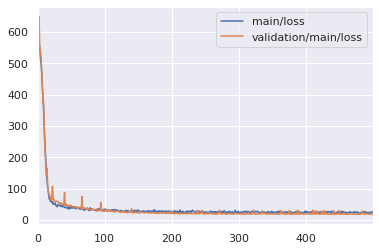

In [58]:
results[["main/loss", "validation/main/loss"]].plot()


In [59]:
loss = results["validation/main/loss"].values[-1]
loss

17.695321053266525

In [60]:
import math 

In [61]:
math.sqrt(loss)

4.207